# Recommender system

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Datasets/Movielens-100k

Mounted at /content/gdrive
/content/gdrive/My Drive/Datasets/Movielens-100k


In [ ]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

MOVIELENS_DIR = "ml-100k"

In [ ]:
# Load the dataset
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


### Q1. Data Preprocessing and Baseline algorithms

(a) Data in recommendation systems is usually encoded as data frame with three or more columns: (user, item, rating, additional meta-data if present). Complete the function **dataPreprocessor** that takes the data frame, total number of users, total number of items and it should output a **`user-item matrix`**. The following experiments will all use **dataPreprocessor**.

(b) In this question, we'll port the baseline algorithms from the lab to our evaluation framework for the assignment. To do so, you need to implement the two baseline algorithms (popularity, user average rating). Please fill in the indicated functions (**popularity**, **useraverage**) in class **BaseLineRecSys**; see comments there for more guidance. The rest of **BaseLineRecSys** has been written for you.

In [ ]:
# Q1-(a)
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# https://stackoverflow.com/questions/34962104/pandas-how-can-i-use-the-apply-function-for-a-single-column
def dataPreprocessor(rating_df, num_users, num_items):
    """
    INPUT: 
        data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
        num_row: int. number of users
        num_col: int. number of items
    OUTPUT:
        matrix: 2D numpy array. 
        
    NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
        
    NOTE 2: data can have more columns, but your function should ignore 
          additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    ###########         end         ###########
    return matrix

In [ ]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [ ]:
# Q1-(b)
# https://numpy.org/devdocs/reference/generated/numpy.ndenumerate.html
# https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
        method: string. From ['popularity','useraverage']
        processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
        Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
        INPUT:
            train_matrix: 2D numpy array.
            num_users: int. Number of Users.
            num_items: int. Number of Items.
        OUTPUT:
            predictionMatrix: 2D numpy array. this is the same dimensions and 
            row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
            there should be a predicted value in predictedMatrix.
            
        NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        for (user, item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # Extract the items the user already rated
            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
        INPUT:
            train_matrix: 2D numpy array.
            num_users: int. Number of Users.
            num_items: int. Number of Items.
        OUTPUT:
            predictionMatrix: 2D numpy array. this is the same dimensions and 
            row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
            there should be a predicted value in predictedMatrix.
            
        NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user, item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
        return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
        return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
        reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")

In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df, copy=True).head()

100000it [01:17, 1296.19it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


In [ ]:
popularity_recsys = BaseLineRecSys('popularity')
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
popularity_recsys.getModel()

array([[0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
popularity_recsys.evaluate_test(rating_df, copy=True).head()

100000it [01:15, 1330.54it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


### Q2. Similarity in Collaborative Filtering
(a) In class **SimBasedRecSys**, there are two similarity measurement functions (**cosine**, **euclidean**). Please fill in the missing part of those functions. Be careful how you convert Euclidean distance to a [0, 1] similarity for use in the recommender. This implementation is very short and should use pairwise distance. (Google for "pairwise distance scikit learn" for a list of distance metrics, more Googling will tell you what they mean.) Which metric works better? Why?

(b) Implement an additional third metric in function **somethingelse** (your choice, see other offerings of pairwise_distance) and justify in a sentence why you think this could be a good similarity metric for user or item comparison in collaborative filtering.

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
        base: string. From ['user', 'item']. User-based Similarity or Item-based
        method: string. From ['cosine', 'euclidean', 'somethingelse']
        processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
        Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
        cosine similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        ###########         end         ###########
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
        euclidean similarity
        INPUT
          rating matrix generated by dataPreprocessor with R rows and C columns. 
        OUTPUT 
          an R x R similarity_matrix S where each S_ij should be the euclidean similarity between row i and row j of the rating matrix.
        """
        ########### your code goes here ###########
        similarity_matrix = 1 /(1 + pairwise_distances(matrix, metric='euclidean'))
        ###########         end         ###########
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
        manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 /(1 + pairwise_distances(matrix, metric='manhattan'))
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_row: scalar. number of users
            num_col: scalar. number of items
        OUTPUT:
            no return... this method assigns the result to self.model
        
        NOTES:
            self.__model should contain predictions for *all* user and items
            (don't worry about predicting for observed (user,item) pairs,
              since we won't be using these predictions in the evaluation)
            (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = 1 - pairwise_distances(train_matrix.T, metric='cosine')
            normalizer = np.matmul(temp_matrix, ii_similarity)
            normalizer[normalizer == 0] = 1e-5
            tt_model = np.matmul(train_matrix, ii_similarity)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(tt_model, axis=0)
            tt_model[:, columns==0] = tt_model[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = tt_model
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
        OUTPUT:
            predictions:  pandas DataFrame. 
                          columns=['userID', 'itemID', 'rating', 'base-method'...]
                          
        NOTE: 1. data can have more columns, but your function should ignore 
              additional columns.
              2. 'base-method' depends on your 'base' and 'method'. For example,
              if base == 'user' and method == 'cosine', 
              then base-method == 'user-cosine'
              3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
        return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
        return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
        reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Analysis: 
* Cosine works better than Euclidean mainly due to length normalization.
* But in our case we also normalized values of Euclidean so both are having overlap in confidence intervals for RMSE.
* For example If I have two users who rated (4,4) and (5,5) two movies they can still be similar because each user has different relative perspectives both of them didnt hate the movie. So in this case cosine works better than Euclidean.
* For example If I have two user who rated (1,1) and (5,5) two movies. Cosine says they are similar but clearly they are not.
* From our results in Q4

```
'user-euclidean': [[1.0319953645887305, 1.013706565892023, 1.031268958300787],
'item-euclidean': [[1.0452460304884215, 1.0157114777932958, 1.0413212192481176,
'user-cosine': [[1.026449013124381, 1.009013080226148, 1.0256951630950135], 
'item-cosine': [[1.0377631264364244, 1.0068242686250732, 1.0333415315874226]
```

* Manhattan is choosen because it calculates the distance of two vectors by absolute differences. It is similar to Euclidean because we are normalizing both of them (similar results checked in bottom). In case of manhattan it is more robust and it requires less calculations.


### Q3. Collaborative Filtering
(a) Leveraging the user-user collaborative filtering example from lab, implement user-user and item-item based collaborative filtering algorithms by filling out the **predict_all** function in class **SimBasedRecSys**. Note that you should implement vectorized versions of collaborative filtering (example give in lab) since loop-based versions will take excessively long to run.

(b) Please use the given class **CrossValidation** to report comparative **RMSE** results (averages and confidence intervals) between user-user and item-item based collaborative filtering for cosine similarity. Can you explain why one method may have performed better? Consider the average number of ratings per user and the average number of ratings per item when you state your answer.

In [ ]:
user_cosine_recsys = SimBasedRecSys('user', 'cosine')

In [ ]:
item_cosine_recsys = SimBasedRecSys('item', 'cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:15, 1324.39it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
        INPUT:
            metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
        Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
        data: pandas DataFrame. 
        pred: string. Column name that corresponding to the prediction
        true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
        data: pandas DataFrame. 
        k: top-k items retrived
        pred: string. Column name that corresponding to the prediction
        true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
        data: pandas DataFrame. 
        k: top-k items relevant
        pred: string. Column name that corresponding to the prediction
        true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
        Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
        5-fold cross-validation
        algorithms: list. a list of algorithms. 
                    eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results

In [ ]:
# How to use CrossValidation Class?
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items, k=5)

Processing algorithm user-cosine


20000it [00:06, 2875.89it/s]
20000it [00:07, 2815.24it/s]
20000it [00:07, 2786.51it/s]
20000it [00:06, 2858.95it/s]
20000it [00:07, 2832.40it/s]


Processing algorithm item-cosine


20000it [00:06, 2876.41it/s]
20000it [00:06, 2875.88it/s]
20000it [00:07, 2822.55it/s]
20000it [00:06, 2866.81it/s]
20000it [00:06, 2894.72it/s]


{'item-cosine': [[1.0334307063086856,
   1.0169957595085215,
   1.0045122531086308,
   1.0099161642550833,
   1.0111907186985918],
  1.0152091203759024,
  1.0014131747526513,
  1.0290050659991534],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [ ]:
q3 = dataPreprocessor(rating_df, num_users, num_items)

In [ ]:
temp_matrix = np.zeros(q3.shape)
temp_matrix[q3.nonzero()] = 1 
sumperrow = np.sum(temp_matrix, axis=1)
averagenumberofratingsperuser = (sumperrow.sum())/943
averagenumberofratingsperitem = (sumperrow.sum())/1682

In [ ]:
averagenumberofratingsperitem

59.45303210463734

In [ ]:
averagenumberofratingsperuser

106.04453870625663

Analysis: 
* The following values are RMSE average, low CI and high CI
'item-cosine': [ 1.020, 1.006, 1.033,
'user-cosine': [ 1.017, 1.009, 1.025,

* If we see the RMSE results the user is performing slightly better because in our case the average number of ratings per user 106 is more than the average number of ratings per item 59. So while using similarity metrics in case of users we have more rich vectors to find out the similar ones. so better predictions.

### Q4. Performance Comparison (not auto-graded)

(a) Please use the given class **CrossValidation** to compare all the recommenders in Q1, Q2 and Q3 (using cosine similarity) on RMSE, P@k, and R@k. Show the cleanly formatted results of this comparison.

(b) Some baselines cannot be evaluated with some metrics? Which ones and why?

(c) What is the best algorithm for each of RMSE, P@k, and R@k? Can you explain why this may be?

(d) Does good performance on RMSE imply good performance on ranking metrics and vice versa? Why / why not?

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

In [ ]:
cv_rmse = CrossValidation('RMSE')
cv_pk = CrossValidation('P@K')
cv_rk = CrossValidation('R@K')

In [ ]:
scores_rmse = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2846.17it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2780.78it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2875.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2885.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2854.62it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2845.82it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2838.74it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2110.67it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2839.02it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2888.75it/s]


Processing algorithm user-cosine


20000it [00:07, 2823.72it/s]
20000it [00:06, 2892.34it/s]
20000it [00:07, 2813.77it/s]
20000it [00:06, 2863.85it/s]
20000it [00:07, 2817.89it/s]


Processing algorithm item-cosine


20000it [00:07, 2847.98it/s]
20000it [00:06, 2871.49it/s]
20000it [00:07, 2838.15it/s]
20000it [00:07, 2776.02it/s]
20000it [00:06, 2884.90it/s]


In [ ]:
scores_pk = cv_pk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2822.54it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2844.29it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2754.42it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2817.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2856.74it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2838.73it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2813.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2877.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2823.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2825.01it/s]


Processing algorithm user-cosine


20000it [00:07, 2789.43it/s]
20000it [00:06, 2874.61it/s]
20000it [00:06, 2865.02it/s]
20000it [00:07, 2856.41it/s]
20000it [00:07, 2805.07it/s]


Processing algorithm item-cosine


20000it [00:06, 2858.07it/s]
20000it [00:07, 2825.32it/s]
20000it [00:07, 2836.51it/s]
20000it [00:06, 2884.14it/s]
20000it [00:06, 2890.40it/s]


In [ ]:
scores_rk = cv_rk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2873.60it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2739.31it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2858.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2863.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2874.45it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2886.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2823.86it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2865.69it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2894.88it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2918.72it/s]


Processing algorithm user-cosine


20000it [00:07, 2856.99it/s]
20000it [00:06, 2891.51it/s]
20000it [00:07, 2840.51it/s]
20000it [00:07, 2809.49it/s]
20000it [00:06, 2874.96it/s]


Processing algorithm item-cosine


20000it [00:07, 2814.74it/s]
20000it [00:06, 2871.32it/s]
20000it [00:06, 2911.74it/s]
20000it [00:06, 2858.35it/s]
20000it [00:06, 2909.89it/s]


Analysis:

(A) 
For each of the metrics the three values are Average, Low CI and high CI.
             Ave LowCI HIgh CI

```
* RMSE {'item-cosine': [ 1.020, 1.006, 1.033,
'popularity': [ 3.159, 3.139, 3.178,
'user-cosine': [ 1.017, 1.009, 1.025,
'useraverage': [ 1.043, 1.028, 1.058,}
P@K
{'item-cosine': [ 0.532, 0.383, 0.680,
'popularity': [ 0.550, 0.405, 0.695,
'user-cosine': [ 0.555, 0.409, 0.702,
'useraverage': [ 0.473, 0.341, 0.605]}
R@K
{'item-cosine': [ 0.474, 0.353, 0.596],
'popularity': [ 0.484, 0.367, 0.601,
'user-cosine': [ 0.486, 0.369, 0.603,
'useraverage': [ 0.441, 0.329, 0.553}
```

(B)
Some baselines cannot be evaluated with some metrics? Which ones and why?

* For User Average This predicts the same average rating for all the movies for a user (for the movies there are no ratings). In this case rank based metrics P@k and R@k cannot be evaluated. For popularity, We cannot use RMSE for popularity becuase the popularity values in this case are between 0 to 1 (because we are not taking the exact rating for calculation we have only taken if the user liked(rating > 4) or not) but the test ratings are from 1 to 5. so RMSE cannot be evaluated



(C)
What is the best algorithm for each of RMSE, P@k, and R@k? Can you explain why this may be?

* P@k and R@k the evaluations are based on ranking (we need to recommend most relavant to each user). For better ranking the similarity metrics are most suitable because the popularity and average are not persnolized to each user. From the results we can say that user cosine average performed slighlty better in both P@K and R@K. For RMSE cosine similarity measures work better becuase the similarity measures predict the rating based on ratings of most similar users or items. We can also see that in case of RMSE similarity measure have better performed.



(D)
Does good performance on RMSE imply good performance on ranking metrics and vice versa? Why / why not?

* No good performance of RMSE doesn't imply good performace on ranking metrics. Becuase RMSE is calulated for all the user ratings wheter he liked it or not irrespective of their rankings. So good RMSE may come at expense of bad ranking of top K. Similarly, in case of ranking metrics we are only concerned about ranking in top k and have no clue about others. So good performance of ranking doesn't necasarily mean good performance of RMSE.

### Q5. Similarity Evaluation (not auto-graded)
(a) Go through the list of movies and pick three not-so-popular movies that you know well. I.e., do not choose "Star Wars" and note that we expect everyone in the class to have chosen different movies. For each of these three movies, list the top 5 most similar movie names according to item-item cosine similarity (you might use a function like numpy argsort).

(b) Can you justify these similarities? Why or why not? Consider that similarity is determined indirectly by users who rated both items.

In [ ]:
q5 = dataPreprocessor(rating_df, num_users, num_items)
q5 = q5.transpose()  
ii_similarity = 1 - pairwise_distances(q5, metric='cosine')
ii_similarity

array([[1.        , 0.40238218, 0.33024479, ..., 0.        , 0.04718307,
        0.04718307],
       [0.40238218, 1.        , 0.27306918, ..., 0.        , 0.07829936,
        0.07829936],
       [0.33024479, 0.27306918, 1.        , ..., 0.        , 0.        ,
        0.09687505],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.09687505, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
                'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
                'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Method 1
def itemTopK(prediction, moviesDataset, itemID, k):
  # Pick top K based on predicted rating
  itemVector = prediction[:,itemID-1]
  topK = nlargest(k+1, range(len(itemVector)), itemVector.take)
  topK = topK[1:]
  namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
  return namesTopK

In [ ]:
itemTopK(ii_similarity, moviesDF, 110, 5)

['Junior (1994)',
 'Angels in the Outfield (1994)',
 'Santa Clause, The (1994)',
 'Made in America (1993)',
 'Corrina, Corrina (1994)']

In [ ]:
itemTopK(ii_similarity, moviesDF, 224, 5)

['Cold Comfort Farm (1995)',
 'Little Odessa (1994)',
 'Big Night (1996)',
 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)',
 'Looking for Richard (1996)']

In [ ]:
# Method 2
listindex = [109,223,526,873,1298]
listmovieid = [110,224,527,874,1299]
final = np.argsort(ii_similarity, axis=1, kind='quicksort', order=None)[:,1676:1682]

for i in listindex:
  movielist = final[i]
  print("Top similar movies to")
  print(moviesDF.iloc[i,1])
  print("are")

  for j in movielist:
      print(moviesDF.iloc[j,1])
  print("\n")

Top similar movies to
Operation Dumbo Drop (1995)
are
Corrina, Corrina (1994)
Made in America (1993)
Santa Clause, The (1994)
Angels in the Outfield (1994)
Junior (1994)
Operation Dumbo Drop (1995)


Top similar movies to
Ridicule (1996)
are
Looking for Richard (1996)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)
Big Night (1996)
Little Odessa (1994)
Cold Comfort Farm (1995)
Ridicule (1996)


Top similar movies to
Gandhi (1982)
are
Casablanca (1942)
Raiders of the Lost Ark (1981)
Forrest Gump (1994)
One Flew Over the Cuckoo's Nest (1975)
Amadeus (1984)
Gandhi (1982)


Top similar movies to
Career Girls (1997)
are
In the Company of Men (1997)
Ice Storm, The (1997)
Ulee's Gold (1997)
Kicked in the Head (1997)
Steel (1997)
Career Girls (1997)


Top similar movies to
Penny Serenade (1941)
are
Love in the Afternoon (1957)
Laura (1944)
Band Wagon, The (1953)
Gay Divorcee, The (1934)
Charade (1963)
Penny Serenade (1941)




B) 

If group of items are similar it means their item vectors are similar. This happens when same user ranked all of the items. In this case the magnitude of their rating doesn't matter becuase we are using cosine metric. only thing which matters if the same users have rated the items or not. For this to happen there could be many reasons like all the movies belonging to a particular genre or all of them have same actor, genre or director.

```
Justify : 
Top similar movies to Career Girls (1997)
are In the Company of Men (1997)
Ice Storm, The (1997)
Ulee's Gold (1997)
Kicked in the Head (1997)
Steel (1997)
Career Girls (1997)
```

All of them have same genre "DRAMA" and all of them are released in same year. In fact the movies all released in same year. So DRAMA lovers of 1990's must have rated all the movies.


### Q6. Testing with different user types (not auto-graded)

(a) Look at a histogram of the number of ratings per user. (Google for \scipy histogram".) Pick a threshold  that you believe divides users with few ratings and those with a moderate to large number of ratings. What  did you choose? Evaluate the RMSE of user-user and item-item collaborative filtering, but in each of the following two cases testing on only users that meet
the following criteria:

1.   Above threshold  of liked items
2.   Below threshold  of liked items

For each of user-user and item-item collaborative filtering, are there any dierences between recommender performance for (i) and (ii)? Can you explain these dierences (or the lack thereof)?

In [ ]:
q6df = dataPreprocessor(rating_df, num_users, num_items)

In [ ]:
temp_matrix = np.zeros(q6df.shape)
temp_matrix[q6df.nonzero()] = 1 
userratingsnumber = np.sum(temp_matrix, axis=1)
#userratingsnumber.shape

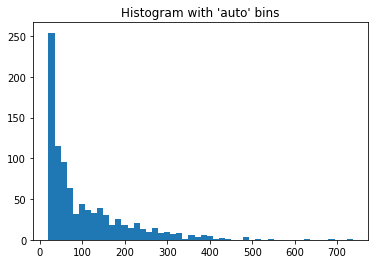

In [ ]:
import matplotlib.pyplot as plt
plt.hist(userratingsnumber, bins=50)
plt.title("Histogram with 'auto' bins")
plt.show()
#userratingsnumber

In [ ]:
np.percentile(userratingsnumber,75)

148.0

In [ ]:
thresholdbelow = np.argwhere(userratingsnumber <= 148).flatten()
len(thresholdbelow)

709

In [ ]:
thresholdabove = np.argwhere(userratingsnumber > 148).flatten()
len(thresholdabove)

234

In [ ]:
class CrossValidationq6above(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            train_set = train_set.loc[train_set['userID'].isin(thresholdabove)]
            
            test_set = getData(data_path, data_types[1].format(i))
            test_set = test_set.loc[test_set['userID'].isin(thresholdabove)]
            
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results

In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances_Q6 = [user_cosine_recsys,
                          item_cosine_recsys]

In [ ]:
cv_patk = CrossValidationq6above('RMSE')
cv_patk.run(algorithm_instances_Q6, num_users, num_items)

Processing algorithm user-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
5690it [00:01, 3144.36it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
5970it [00:01, 3284.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
5067it [00:01, 3154.65it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
4833it [00:01, 3044.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
4869it [00:01, 3323.75it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
5690it [00:01, 2957.34it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
5970it [00:01, 3103.08it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
5067it [00:01, 3085.33it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
4833it [00:01, 2910.88it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
4869it [00:01, 3014.85it/s]


{'item-cosine': [[1.0320705332140439,
   1.0303344025835743,
   1.009264637240564,
   1.013847317185086,
   1.0242143187710053],
  1.0219462417988545,
  1.0094611518447707,
  1.0344313317529383],
 'user-cosine': [[1.0503720301028903,
   1.0760128059562617,
   1.0570055555699578,
   1.054340869987063,
   1.0468077895648276],
  1.0569078102362,
  1.042800757991966,
  1.0710148624804339]}

In [ ]:
class CrossValidationq6below(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            train_set = train_set.loc[train_set['userID'].isin(thresholdbelow)]
            
            test_set = getData(data_path, data_types[1].format(i))
            test_set = test_set.loc[test_set['userID'].isin(thresholdbelow)]
            
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results

In [ ]:
cv_patk = CrossValidationq6below('RMSE')
cv_patk.run(algorithm_instances_Q6, num_users, num_items,k=5)

Processing algorithm user-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
14310it [00:04, 2950.22it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
14030it [00:04, 2978.51it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
14933it [00:04, 3012.70it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
15120it [00:05, 2938.17it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
15010it [00:05, 2931.27it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
14310it [00:04, 3031.98it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
14030it [00:04, 2899.93it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
14933it [00:05, 2923.21it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
15120it [00:04, 3028.05it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
15010it [00:05, 2900.67it/s]


{'item-cosine': [[1.0372175391503462,
   1.0133347175697316,
   1.0042827850513003,
   1.0094138887125197,
   1.005713578907237],
  1.013992501878227,
  0.997292029923097,
  1.030692973833357],
 'user-cosine': [[1.0292964812509109,
   1.0134988342423394,
   1.0162441815962555,
   1.0083129744573012,
   1.0168529851897112],
  1.0168410913473036,
  1.0072353809052537,
  1.0264468017893535]}

Q6) Analysis

* For each metric the ave, low cI and high cI are considered.

```
{'item-cosine': [ 1.022, 1.006, 1.039,
'user-cosine': [ 1.016, 1.007, 1.026}
Above
{'item-cosine': [ 1.051, 1.029, 1.073,
'user-cosine': [ 1.056, 1.042, 1.071]}
Full members 
{'item-cosine': [ 1.020, 1.006, 1.033,
'user-cosine': [ 1.017, 1.009, 1.025}
```

* The RMSE values of below are less than Above. so the below perfomed better becuase in case for below we have more points (can see the number of iterations) and more vectors so better predictions. In the same way for full members as it has more information than either of the cases it performed slightly better.
* But the above analysis cannot be generalized unless I see the other k values. Even I am changing the K values by 10 there is more diffence. There is tradeoof between number of vectors and number of ratings inside a vector

In [ ]:
# Validation
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(path, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()


### Baseline Recommendation Systems

#### Popularity Based Recommendation


In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

validatePopularityRecSys()

#### User Average Based Recommendation



In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

validateUserAverRecSys()



### Similary Based Recommendation Systems

#### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

validateEuclidean()

#### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

validateCustomizedSim()

#### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

validateUUSimBasedRecSys()

#### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

validateIISimBasedRecSys()